In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()
            
            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]
                
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        
        #comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        #'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }

    return data, messages

In [3]:
def crawl_comment(amount=50):

    all_data = []
    comments = []
    counter = 0
    nextPage = PTT_URL

    while counter <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                #如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(all_data) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data, comments
                
                # 呼叫上面寫好的 function 來對文章進行爬蟲
                parse_data, parse_comment = crawl_article(article_URL)
                #parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))
                
                '''
                if counter > amount:
                    time.sleep(2)
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data
                '''

                # 將爬完的資料儲存
                all_data.append(parse_data)
                comments.extend(parse_comment)
                
                counter += 1

    return all_data, comments

In [4]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [5]:
def getStopWord():
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [6]:
def jiebaWord(content, topk=20):
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list2 = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list2)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list2.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    

In [7]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [8]:
def splitMessage(data):
    message_info = list()

    for row in data:

        messages = row['messages']
        if messages:
            for message in messages:
                message_info.extend(messages)
    
    message_info = list(set(message_info))
    
    return message_info

In [9]:
def jiebaCount(data, columnName, isData = True, topK = 20):
    all_content = ''
    
    if isData:
        for d in data:
            all_content += d[columnName]

        content_pd, content_tags = jiebaWord(all_content, topK)
    else:
        for val in data:
            if val:
                values = [d[columnName] for d in val]
                all_content += ''.join(values)
        content_pd, content_tags = jiebaWord(all_content, topK)
    
    return content_pd, content_tags

In [10]:
data, comments = crawl_comment(50)
save_data(data)

Parse [黑特] 賴清德好爽，生活悠閒自在 - https://www.ptt.cc/bbs/HatePolitics/M.1612709661.A.A6B.html
Parse Re: [討論] 沒有蔡英文的民進黨 - https://www.ptt.cc/bbs/HatePolitics/M.1612709731.A.2B5.html
Parse Re: [討論] 沒有蔡英文的民進黨 - https://www.ptt.cc/bbs/HatePolitics/M.1612710304.A.E29.html
Parse Re: [討論] 罷免陳柏惟 沒有比較簡單吧 - https://www.ptt.cc/bbs/HatePolitics/M.1612710403.A.129.html
Parse [討論] 總統直選以來KMT應該算是沒輸過 - https://www.ptt.cc/bbs/HatePolitics/M.1612711040.A.B19.html
Parse Re: [討論] 美國為台灣作戰會不會有傷亡啊？ - https://www.ptt.cc/bbs/HatePolitics/M.1612711221.A.110.html
Parse [討論] 美國、歐盟 將要制裁 緬甸將領 - https://www.ptt.cc/bbs/HatePolitics/M.1612711356.A.AC1.html
Reach the last article of this page
Parse Re: [討論] 罷免陳柏惟 沒有比較簡單吧 - https://www.ptt.cc/bbs/HatePolitics/M.1612704043.A.DC8.html
Parse Re: [討論] 現在女生的政治傾向比較綠嗎? - https://www.ptt.cc/bbs/HatePolitics/M.1612704400.A.925.html
Parse [討論] 趙少康、柯文哲罷免喊卡 引起柯韓粉反彈了 - https://www.ptt.cc/bbs/HatePolitics/M.1612704822.A.619.html
Parse [討論] 罷免權是否是多餘的權力 - https://www.ptt.cc/bbs/HatePolitics/M.1

In [11]:
content_pd, content_tags = jiebaCount(data, 'article_content', 10)

Building prefix dict from /Users/GaryWu/Desktop/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.ub54ea009f7053a6e7164f33a0c3f57e9.cache
Loading model cost 2.456 seconds.
Prefix dict has been built successfully.


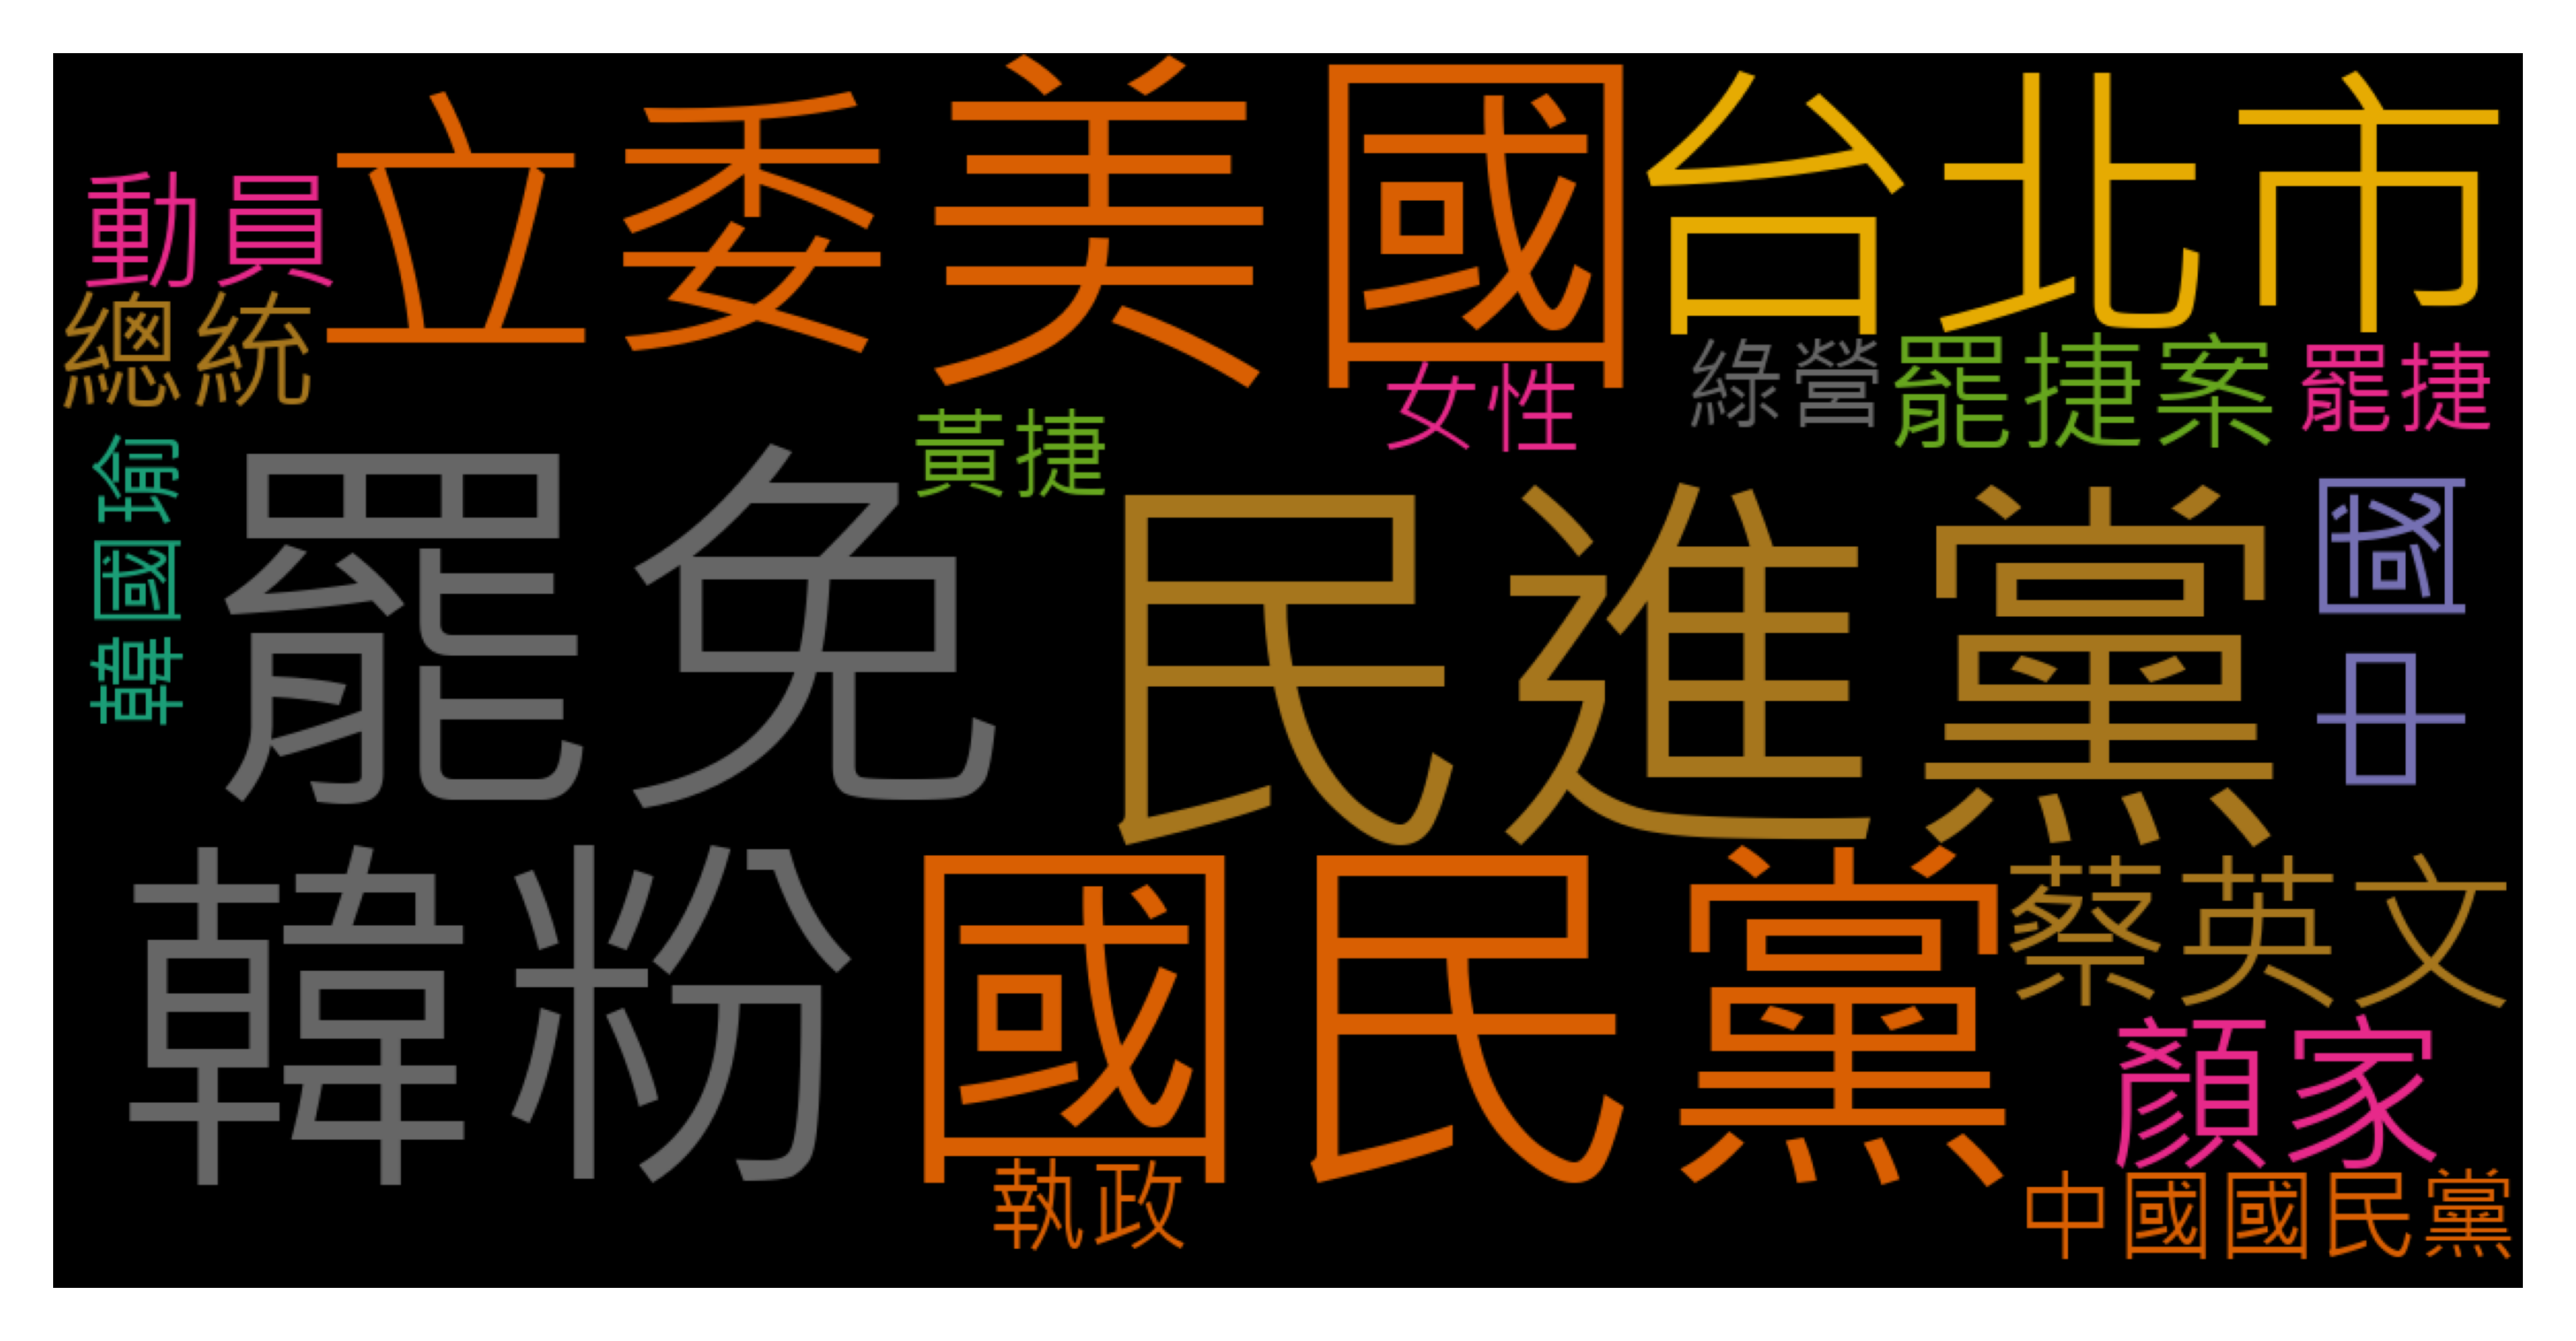

In [12]:
wordcloudPTT(content_tags)

In [13]:
content_pd.sort_values(by=['Times'], ascending = False)

,KeyWords,Times
0,罷免,104
1,民進黨,63
2,國民黨,56
3,韓粉,46
5,台北市,43
4,美國,41
19,女性,28
7,蔡英文,26
8,顏家,25
9,中國,25


In [14]:
comments[1]

{'push_tag': '推',
 'push_userid': 'jt13',
 'push_content': '賴阿~~鄭太油了',
 'push_ipdatetime': '02/07 23:01'}

In [15]:
message_pd, message_tags = jiebaCount(comments, 'push_content', True, 40)

Building prefix dict from /Users/GaryWu/Desktop/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.ub54ea009f7053a6e7164f33a0c3f57e9.cache
Loading model cost 2.602 seconds.
Prefix dict has been built successfully.


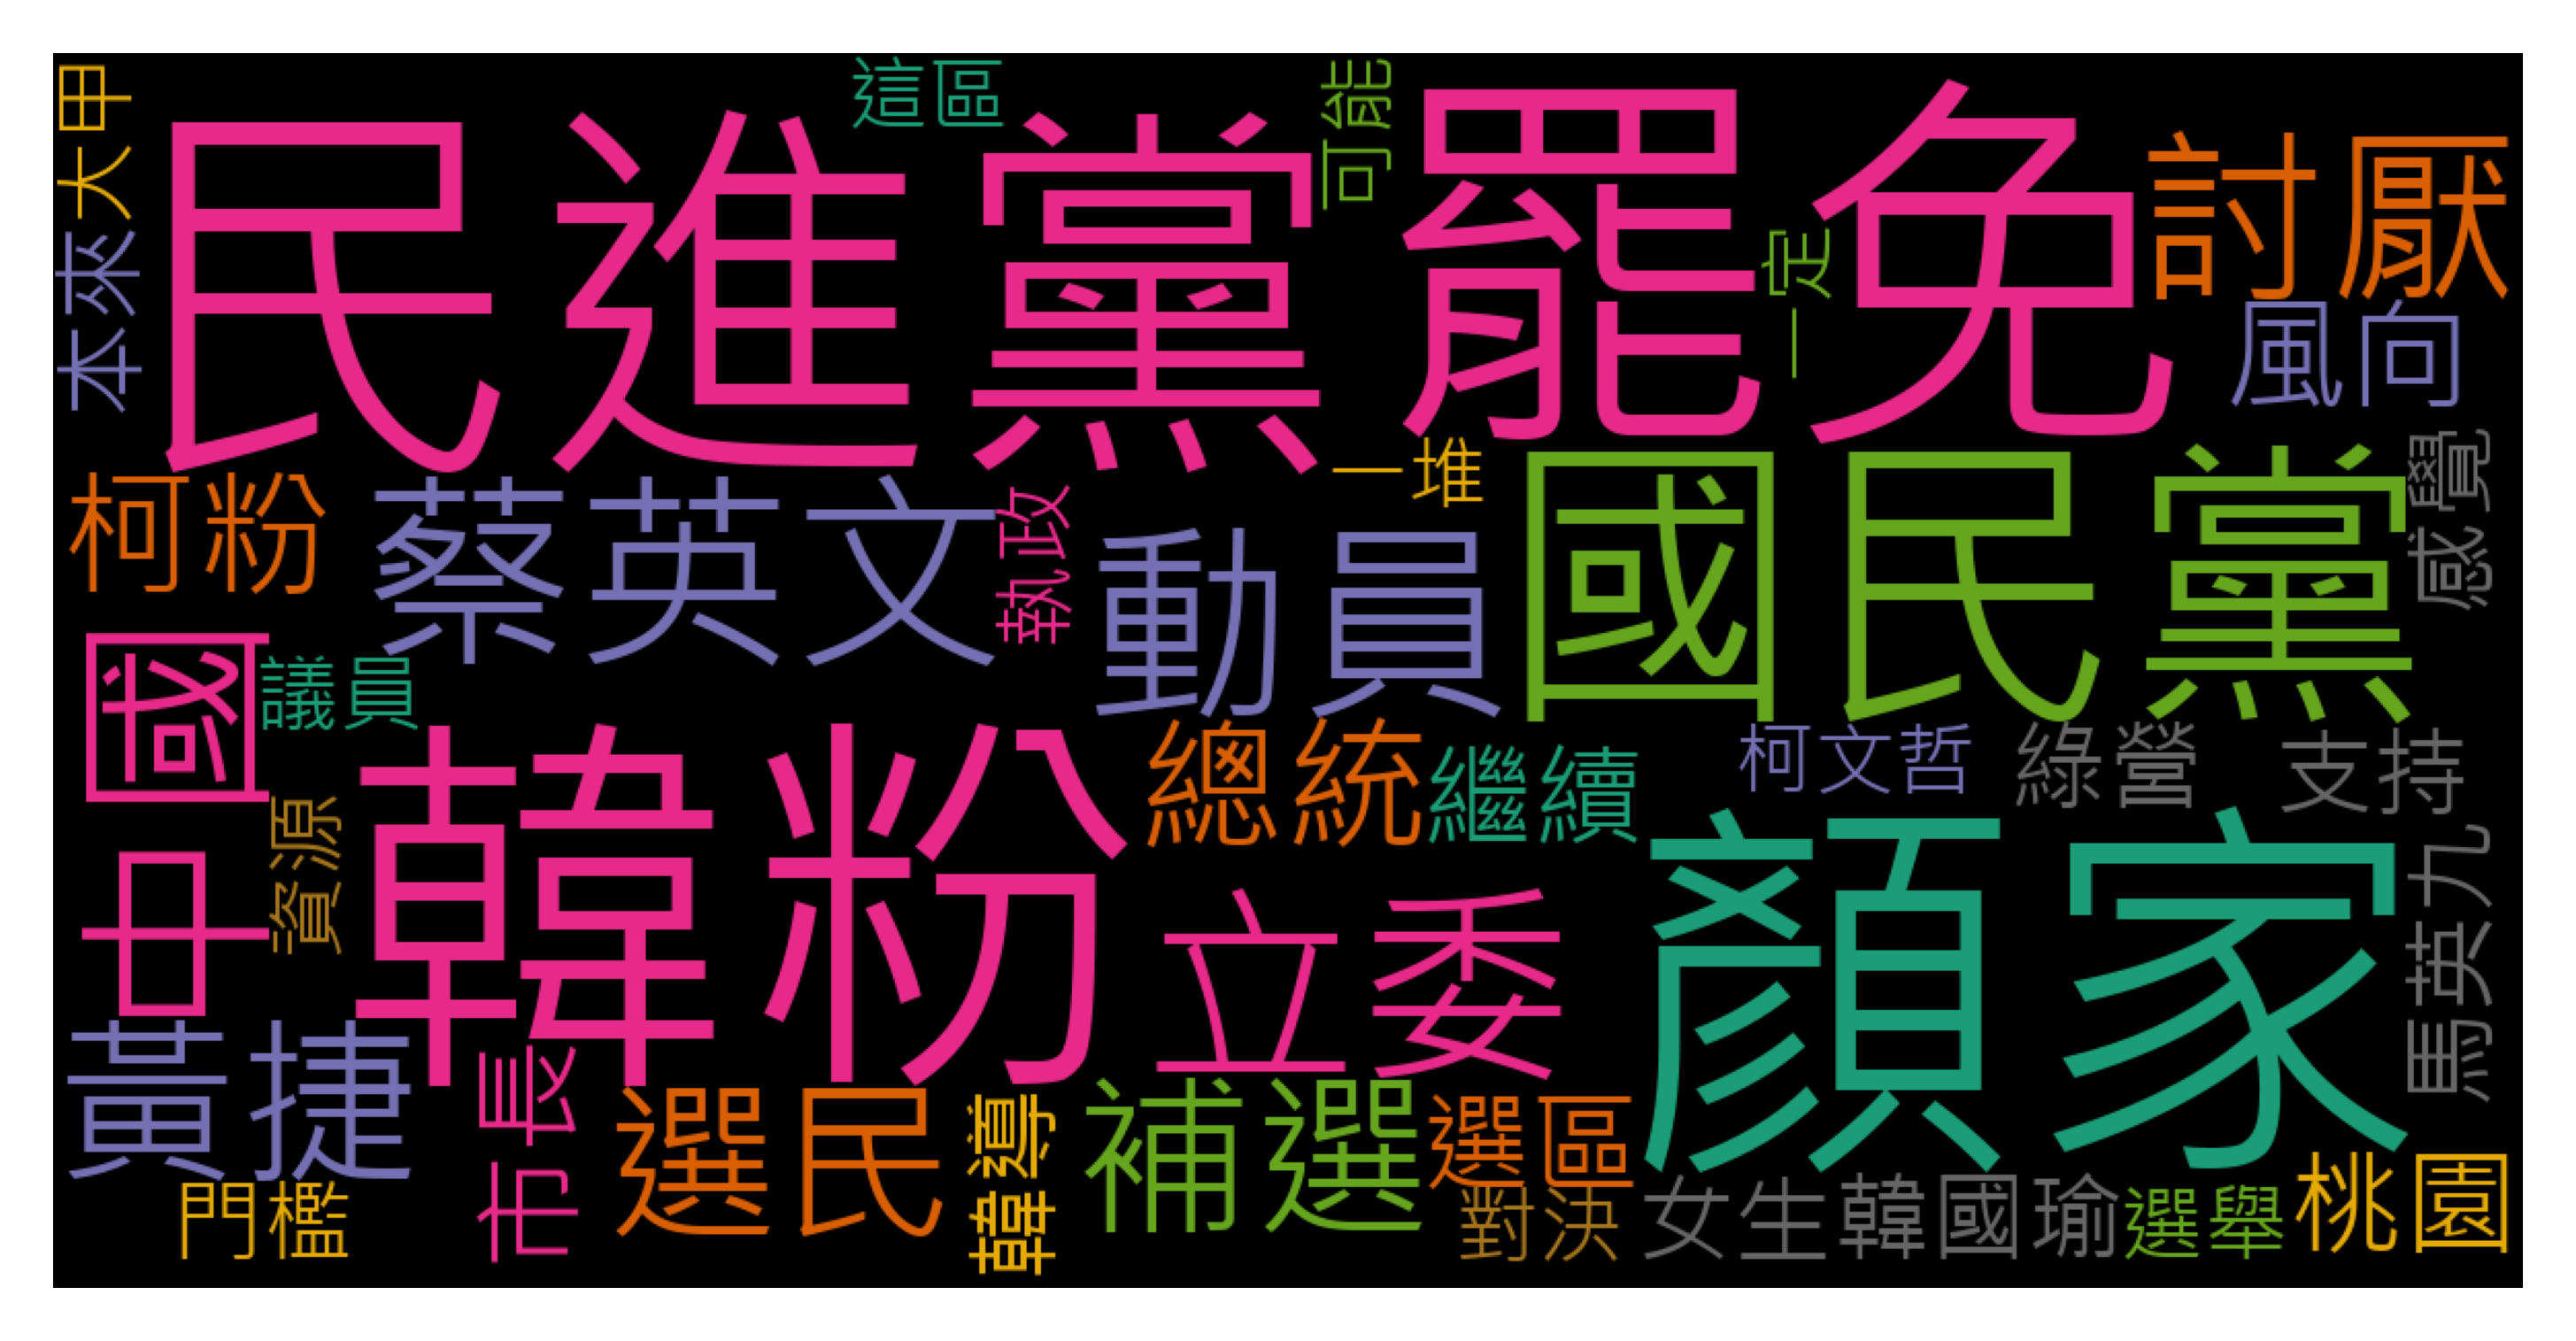

In [16]:
wordcloudPTT(message_tags)

In [17]:
commentpd = pd.DataFrame(comments)
commentpd.head(100)

,push_tag,push_userid,push_content,push_ipdatetime
0,推,jajujo,那誰要出來選,02/07 22:54
1,推,jt13,賴阿~~鄭太油了,02/07 23:01
2,噓,miler22020,唯一支持賴,02/07 23:02
3,→,nicholas0406,副總統就是這樣阿,02/07 23:05
4,→,DANANPA,賴清德不要像柯P四處放炮樹敵，趁現在韜光養晦，將來還是,02/07 23:05
...,...,...,...,...
95,→,ms0443001,再怎麼不濟 前兩大黨永遠輪不到白色 放心,02/07 23:00
96,→,Andrew90,韓再起 552萬起跳開始算 00,02/07 23:07
97,推,godispower,我對於財政這一塊能把馬英九的爛攤子收回來，現在不管,02/07 23:07
98,→,godispower,你要紓困，建設，股市，說實在的財政這一塊蔡英文真的,02/07 23:07


In [18]:
def articleCollect(inputpd, author, content, times):
        ## 整理每個推/發文id的全部發文
        ##     每個推/發文ip的全部id
        temp = []
        for name in inputpd[author]: # 抓每個發/推文者的id/ip
            if not name in temp:
                temp.append(name)
        tempD = pd.DataFrame(temp)   # 將每個發/推文者的id/ip預先變成dataframe以便後續填補資料
        tempD = tempD.rename({0:author}, axis='columns')
        temp = []       # 裝每個發/推文者的id/ip
        tempL = []      # 裝每個id/ip的推/發文數或推/發文人數
        allArticle = '' # 全部發文內容彙整 -> 了解最近大家關心的
        pdCount = 0
        for name in tempD[author]:
            temppd = inputpd[inputpd[author]==name]
            for detail in temppd[content]:
                if ('author' in author)*('article' in content):
                    allArticle += detail+' ' # 全部發文內容彙整 -> 了解最近大家關心的
                try:
                    if ('ip' in author):
                        if not detail in temp[pdCount]:
                            temp[pdCount] = temp[pdCount]+';'+detail        
                    else:
                        temp[pdCount] = temp[pdCount]+';'+detail        
                except:
                    temp.append(detail)     
            if ('ip' in author):
                tempL.append(len(temp[pdCount].split(';'))) # 拿到ip -> 整理此ip有幾人用
            else:
                tempL.append(len(temppd[content]))          # 沒拿到ip -> 整理此id發/推過幾篇文
            pdCount +=1
        tempD[content] = temp
        tempD[times] = tempL
        tempD = tempD.sort_values(by=times, ascending=False).reset_index()
        '''
        if ('author' in author)*('article' in content):  
            self.allArticle = allArticle
        '''
        return tempD

In [19]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [20]:
pddata_byname = articleCollect(pddata, 'article_author_id', 'article_content', 'article_times')

In [21]:
pddata_byname

,index,article_author_id,article_content,article_times
0,5,dusty1021,: 綠營支持者國內一直鬥國民黨也沒用 : 真的面對對岸大魔王就一點輒也沒有 : 很多人一直在...,2
1,10,DingLey,很多國家其實只有選沒有罷\n星日韓俄德法英加...\n還一堆都是進步國家呢\n\n我覺得說只...,2
2,39,JamesSoong,拜登上台後 綠共馬上就改稱新冠肺炎了 還唾面自乾說是與國際通稱接軌\n\n ...,2
3,0,brella,剛剛看了賴清德的臉書，真他媽爽，\n拜訪了臺灣導盲犬協會，看著戴著口\n罩的賴清德，仔細關心...,1
4,36,tso2054852,罷捷失敗後韓粉們士氣大振，\n\n紛紛都喊沒有輸，\n\n迫不期待把刀揮向3Q哥，\n\n有...,1
5,27,chirex,: 雞排妹遭性騷擾 柯文哲沈默10秒：藝人總是要炒話題 : ETTODAY : 2021年0...,1
6,28,owo0204,分享一下個人的觀察\n以下樣本數超少 自己斟酌看\n\n\n1.年輕女性是否偏綠？\n\n我...,1
7,29,slcgboy,辛丑新年春節樂透\n請到 HatePolitics 板 按f參與樂透\n\n一張 50 Pt...,1
8,30,liam1984,幹你柯韓粉八卦肥宅\n\n成天看vtuber尻尻\n\n來政黑一直peko peko pe三...,1
9,31,Zcould,你好，我就是Zcould，我請你進來有事想請教：\n你哪個選區？像你這樣的人才什麼時候要宣布...,1


In [22]:
def CollectInfo(inputData, author, content, times):
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id/ip
    articleCount = []      # 裝每個id/ip的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [23]:
hi = pddata[pddata['article_author_id'] == 'neutron']
count = 0
user_id = []

for info in hi['article_content']:

    if len(user_id) > count:
        user_id[count] = user_id[count] + ';' + info
    else:
        user_id.append(info)
    print(info)
    print('**************')
    
    count += 1

In [24]:
pddata_info = CollectInfo(pddata, 'article_author_id', 'article_content', 'article_times')
comment_data = CollectInfo(commentpd, 'push_userid', 'push_content', 'push_times')

In [25]:
pddata_info

,index,article_author_id,article_content,article_times
0,5,dusty1021,: 綠營支持者國內一直鬥國民黨也沒用 : 真的面對對岸大魔王就一點輒也沒有 : 很多人一直在...,2
1,10,DingLey,很多國家其實只有選沒有罷\n星日韓俄德法英加...\n還一堆都是進步國家呢\n\n我覺得說只...,2
2,39,JamesSoong,拜登上台後 綠共馬上就改稱新冠肺炎了 還唾面自乾說是與國際通稱接軌\n\n ...,2
3,0,brella,剛剛看了賴清德的臉書，真他媽爽，\n拜訪了臺灣導盲犬協會，看著戴著口\n罩的賴清德，仔細關心...,1
4,36,tso2054852,罷捷失敗後韓粉們士氣大振，\n\n紛紛都喊沒有輸，\n\n迫不期待把刀揮向3Q哥，\n\n有...,1
5,27,chirex,: 雞排妹遭性騷擾 柯文哲沈默10秒：藝人總是要炒話題 : ETTODAY : 2021年0...,1
6,28,owo0204,分享一下個人的觀察\n以下樣本數超少 自己斟酌看\n\n\n1.年輕女性是否偏綠？\n\n我...,1
7,29,slcgboy,辛丑新年春節樂透\n請到 HatePolitics 板 按f參與樂透\n\n一張 50 Pt...,1
8,30,liam1984,幹你柯韓粉八卦肥宅\n\n成天看vtuber尻尻\n\n來政黑一直peko peko pe三...,1
9,31,Zcould,你好，我就是Zcould，我請你進來有事想請教：\n你哪個選區？像你這樣的人才什麼時候要宣布...,1


In [26]:
comment_data

,index,push_userid,push_content,push_times
0,17,smallweek,2024目前看就是賴清德;去年立委選舉民進黨桃園就選不好了，六都就桃園選得最;不符合預期;如...,85
1,5,quiet93,答應當副總統時，就知道是政治生涯最後一個職位了;什麼形象，執政無能的形象嗎，別鬧了;2024...,46
2,112,Atkins13,33%就是回到最一開始的門檻而已;韓粉(或韓流)基本上就是戰後嬰兒潮為主力的政治啟蒙啊;只是...,44
3,44,hlcian,哇 這樣真的難了 那次補選新聞很大 雙方都是全力動員;罷免的人跟錢又不是朱出的他是在靠北三小...,41
4,80,MVPGGYY,朱學恆怎麼變成藍到深藍去了？;韓國瑜紅的時候他去蹭韓蹭的超明顯的......;結果是拖高雄出...,41
...,...,...,...,...
307,215,ssd860505da,ok peko ok peko PEKOPEKOPE,1
308,214,skylove21,Ahoy可以嗎啵,1
309,213,mattys410305,peko,1
310,131,holysong,推分析,1
